In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

num_gpus = torch.cuda.device_count()
print("Number of available GPUs:", num_gpus)
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device_index = 0
device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() and device_index < num_gpus else "cpu")
print("Using device:", device)

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda:0


#### model

In [47]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#### functions

In [4]:
# analytical solution
def exact_solution(x, omega):
    return (1 / omega) * torch.sin(omega * x)


##### total cost function

In [5]:
# residual cost
def residual_loss(model, x, omega):
    u = model(x)
    dudx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0].to(device)
    physics_loss = torch.mean((dudx - torch.cos(omega * x)) ** 2).to(device)
    return physics_loss

# beginning condition cost
def boundary_loss(model):
    u0 = model(torch.tensor([0.0]).view(-1, 1).requires_grad_(True).to(device)).to(device)
    return (torch.squeeze(u0) ** 2).to(device)

# total cost function
def total_loss(model, x, omega):
    return (residual_loss(model, x, omega) + boundary_loss(model)).to(device)


##### plotting function

In [6]:
def plot_solution(model, x_test, x_train, u_exact, costs, epochs):
    with torch.no_grad():
        x_test = x_test.to(device)
        x_train = x_train.to(device)
        
        u_pred = model(x_test)
        
        x_test_cpu = x_test.cpu().numpy()
        u_pred_cpu = u_pred.cpu().numpy()
        u_exact_cpu = u_exact.cpu().numpy()
        x_train_cpu = x_train.cpu().detach().numpy()
        
        fig, axs = plt.subplots(3, figsize=(12, 16))
        
        # Solution plot
        axs[0].plot(x_test_cpu, u_exact_cpu, label='Exact Solution', color='blue')
        axs[0].plot(x_test_cpu, u_pred_cpu, label='PINN Solution', color='red', linestyle='dashed')
        axs[0].scatter(x_train_cpu, model(x_train).cpu().detach().numpy(), color='black', s=1)
        axs[0].set_title(f'Solution after {epochs} epochs')  # Use set_title instead of title
        axs[0].legend()

        # Error function plot
        axs[1].plot(x_test_cpu, abs((u_exact_cpu - u_pred_cpu)).reshape(-1, 1), label='Error Function', color='red')
        axs[1].set_title('Error Function')  # Use set_title instead of title
        axs[1].legend()

        # Loss function plot
        axs[2].plot(np.arange(epochs+1), costs, label='Cost Function', color='purple')
        axs[2].set_title('Cost function')  # Use set_title instead of title
        axs[2].set_xlabel('Epochs')  # Use set_xlabel instead of xlabel
        axs[2].set_ylabel('Cost function')  # Use set_ylabel instead of ylabel
        axs[2].legend()

        plt.show()


#### train

In [7]:
# training function

def train(model, omega, cost_function, epochs, x_train, lr):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    costs = []
    
    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        
        loss = cost_function(model, x_train, omega)
        loss.backward()
        
        optimizer.step()
        
        costs.append(loss.cpu().detach().numpy())
        
        if epoch % (epochs // 10) == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss:.2e}')

    return model, costs

#### constants

In [8]:
N_INPUT = 1
N_OUTPUT = 1
LR = 0.001
EPOCHS = 50_000

#### a)

In [9]:
OMEGA = 1
N_HIDDEN = 16
N_LAYERS = 2
TRAINING_POINTS = 200
TESTING_POINTS = 1_000

x_train_a = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

x_train_a = x_train_a.to(device)

model_a = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_a = model_a.to(device)


In [69]:
model_a, costs_a = train(model_a, OMEGA, total_loss, EPOCHS, x_train_a, LR)

model_test_a = model_a

Epoch 0/50000, Loss: 4.79e-01
Epoch 5000/50000, Loss: 4.61e-05
Epoch 10000/50000, Loss: 4.53e-06
Epoch 15000/50000, Loss: 1.60e-06
Epoch 20000/50000, Loss: 1.17e-06
Epoch 25000/50000, Loss: 1.18e-06
Epoch 30000/50000, Loss: 7.55e-07
Epoch 35000/50000, Loss: 6.15e-07
Epoch 40000/50000, Loss: 5.55e-07
Epoch 45000/50000, Loss: 7.35e-06
Epoch 50000/50000, Loss: 1.31e-06


In [70]:
x_test_a = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_a = exact_solution(x_test_a, OMEGA)

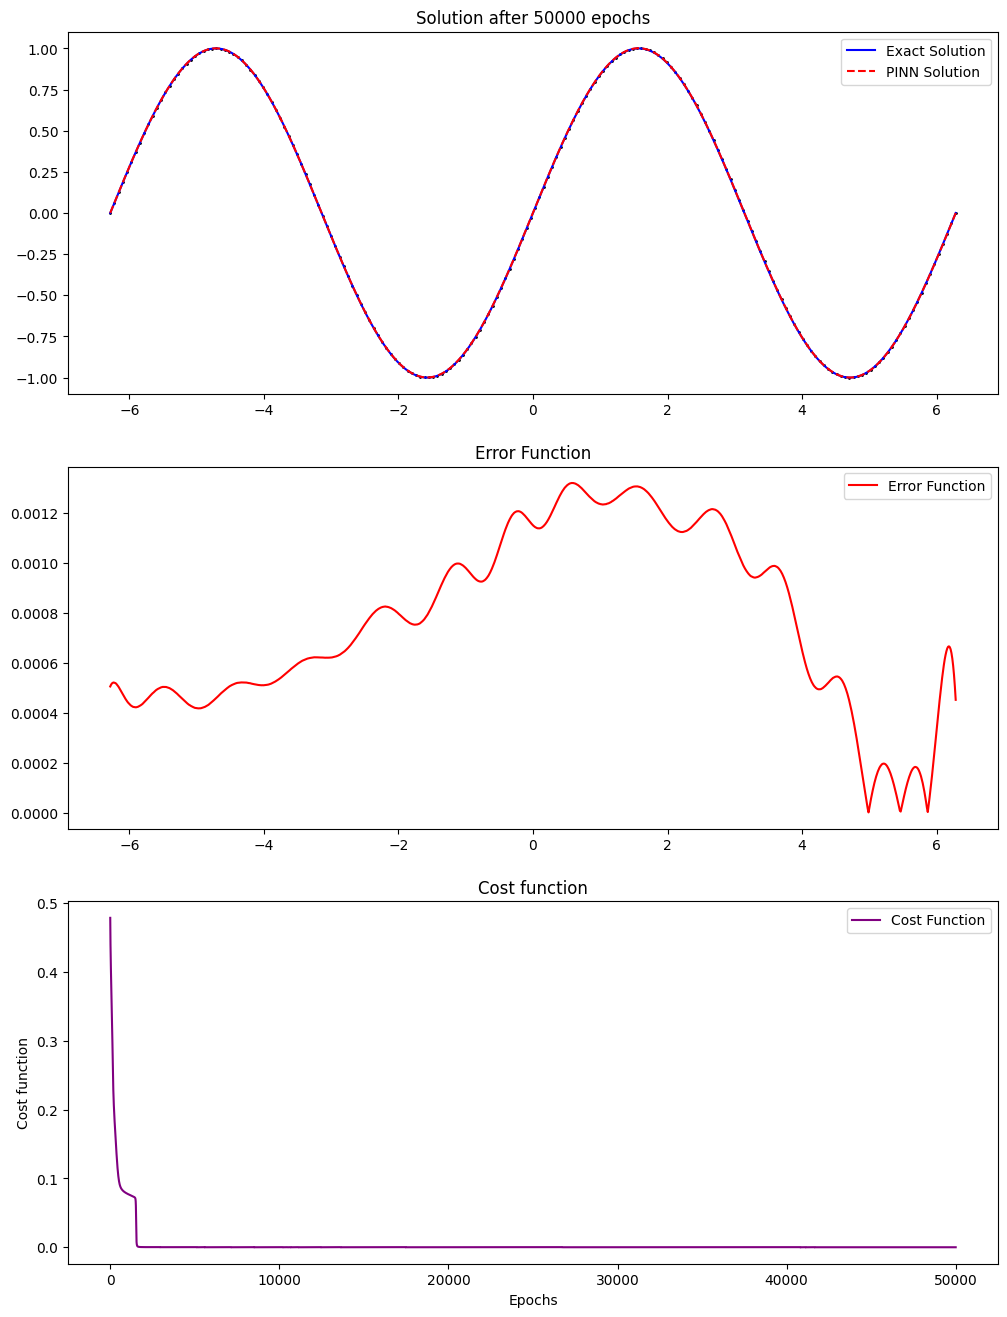

In [71]:
plot_solution(model_test_a, x_test_a, x_train_a, u_exact_a, costs_a, EPOCHS)

#### b)

In [44]:
OMEGA = 15
TRAINING_POINTS = 3_000
TESTING_POINTS = 5_000

x_train_b = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

x_train_b = x_train_b.to(device)

##### 1)

In [45]:
N_HIDDEN = 16
N_LAYERS = 2

model_b1 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_b1 = model_b1.to(device)

In [46]:
model_b1, costs_b1 = train(model_b1, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b1 = model_b1

Epoch 0/50000, Loss: 5.33e-01
Epoch 5000/50000, Loss: 5.00e-01
Epoch 10000/50000, Loss: 5.00e-01
Epoch 15000/50000, Loss: 5.00e-01
Epoch 20000/50000, Loss: 5.00e-01
Epoch 25000/50000, Loss: 4.48e-01
Epoch 30000/50000, Loss: 3.60e-01
Epoch 35000/50000, Loss: 3.41e-01
Epoch 40000/50000, Loss: 3.36e-01
Epoch 45000/50000, Loss: 3.34e-01
Epoch 50000/50000, Loss: 3.01e-01


In [47]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b1 = exact_solution(x_test_b, OMEGA)

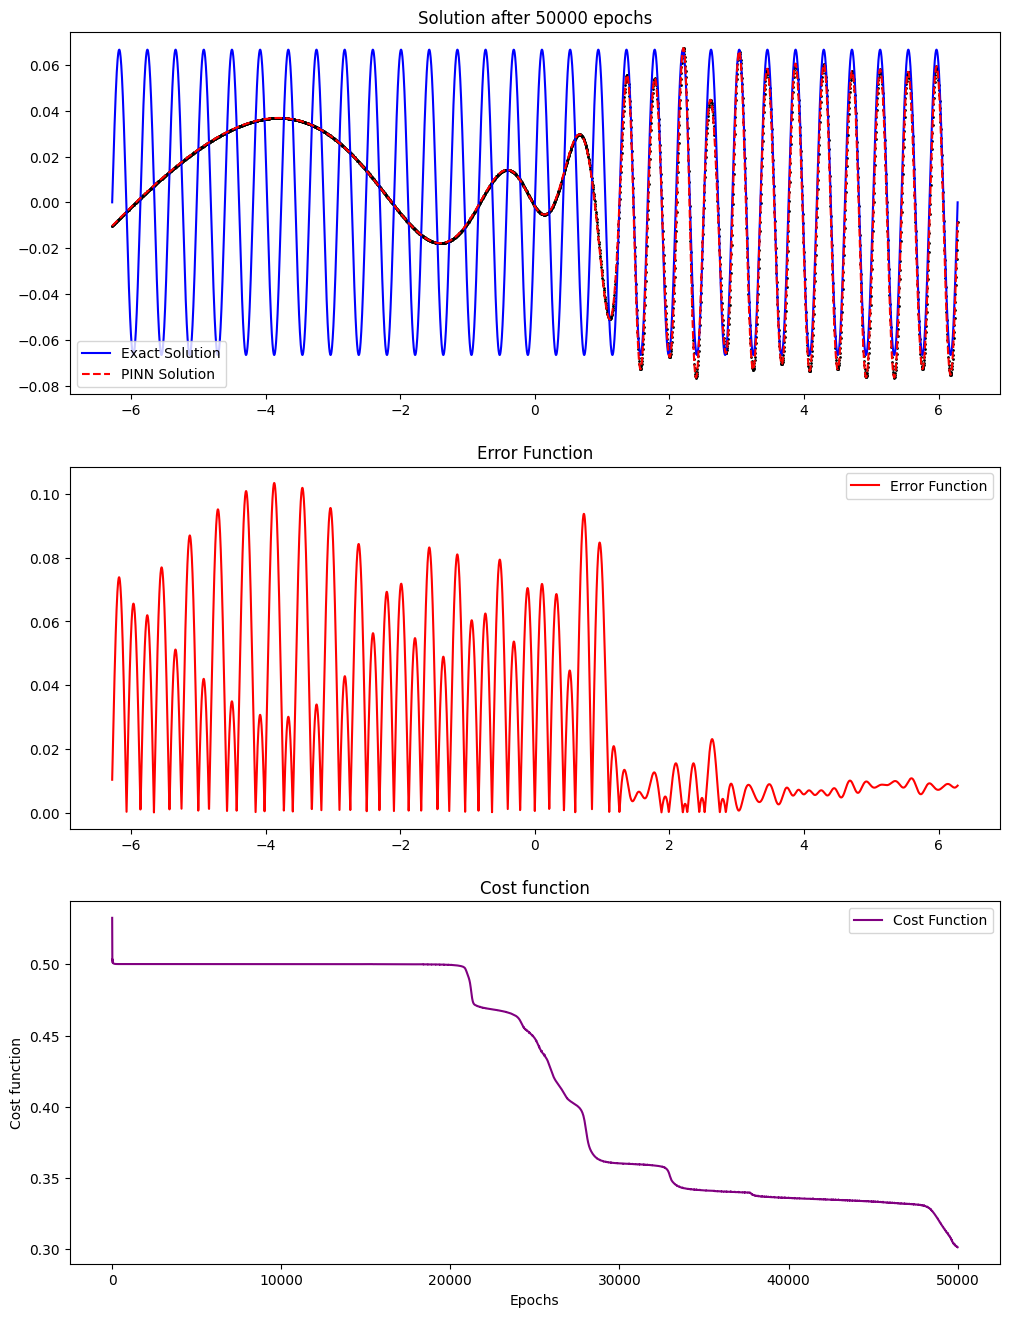

In [48]:
plot_solution(model_test_b1, x_test_b, x_train_b, u_exact_b1, costs_b1, EPOCHS)

##### 2)

In [49]:
N_HIDDEN = 64
N_LAYERS = 4

model_b2 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_b2 = model_b2.to(device)

In [50]:
model_b2, costs_b2 = train(model_b2, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b2 = model_b2

Epoch 0/50000, Loss: 5.06e-01
Epoch 5000/50000, Loss: 5.00e-01
Epoch 10000/50000, Loss: 5.00e-01
Epoch 15000/50000, Loss: 2.71e-01
Epoch 20000/50000, Loss: 1.57e-01
Epoch 25000/50000, Loss: 1.19e-01
Epoch 30000/50000, Loss: 8.69e-02
Epoch 35000/50000, Loss: 7.05e-02
Epoch 40000/50000, Loss: 6.94e-02
Epoch 45000/50000, Loss: 5.94e-02
Epoch 50000/50000, Loss: 3.64e-02


In [51]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b2 = exact_solution(x_test_b, OMEGA)

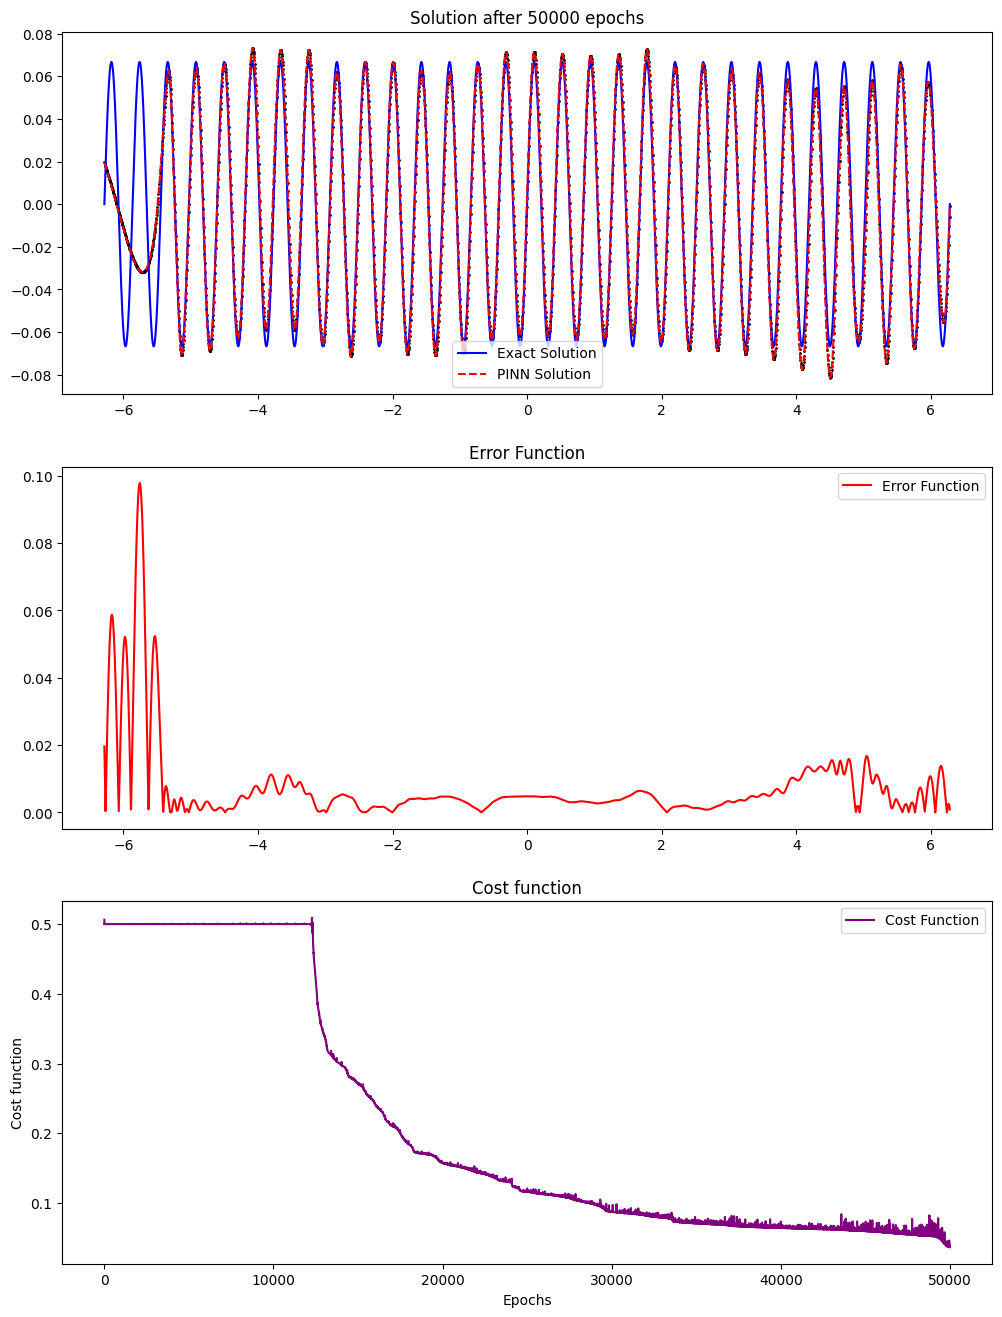

In [52]:
plot_solution(model_test_b2, x_test_b, x_train_b, u_exact_b2, costs_b2, EPOCHS)

##### 3)

In [53]:
N_HIDDEN = 128
N_LAYERS = 5

model_b3 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_b3 = model_b3.to(device)

In [54]:
model_b3, costs_b3 = train(model_b3, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b3 = model_b3

Epoch 0/50000, Loss: 5.09e-01
Epoch 5000/50000, Loss: 5.00e-01
Epoch 10000/50000, Loss: 5.00e-01
Epoch 15000/50000, Loss: 5.00e-01
Epoch 20000/50000, Loss: 5.00e-01
Epoch 25000/50000, Loss: 5.00e-01
Epoch 30000/50000, Loss: 5.00e-01
Epoch 35000/50000, Loss: 5.00e-01
Epoch 40000/50000, Loss: 1.02e-01
Epoch 45000/50000, Loss: 1.30e-03
Epoch 50000/50000, Loss: 6.76e-03


In [55]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b3 = exact_solution(x_test_b, OMEGA)

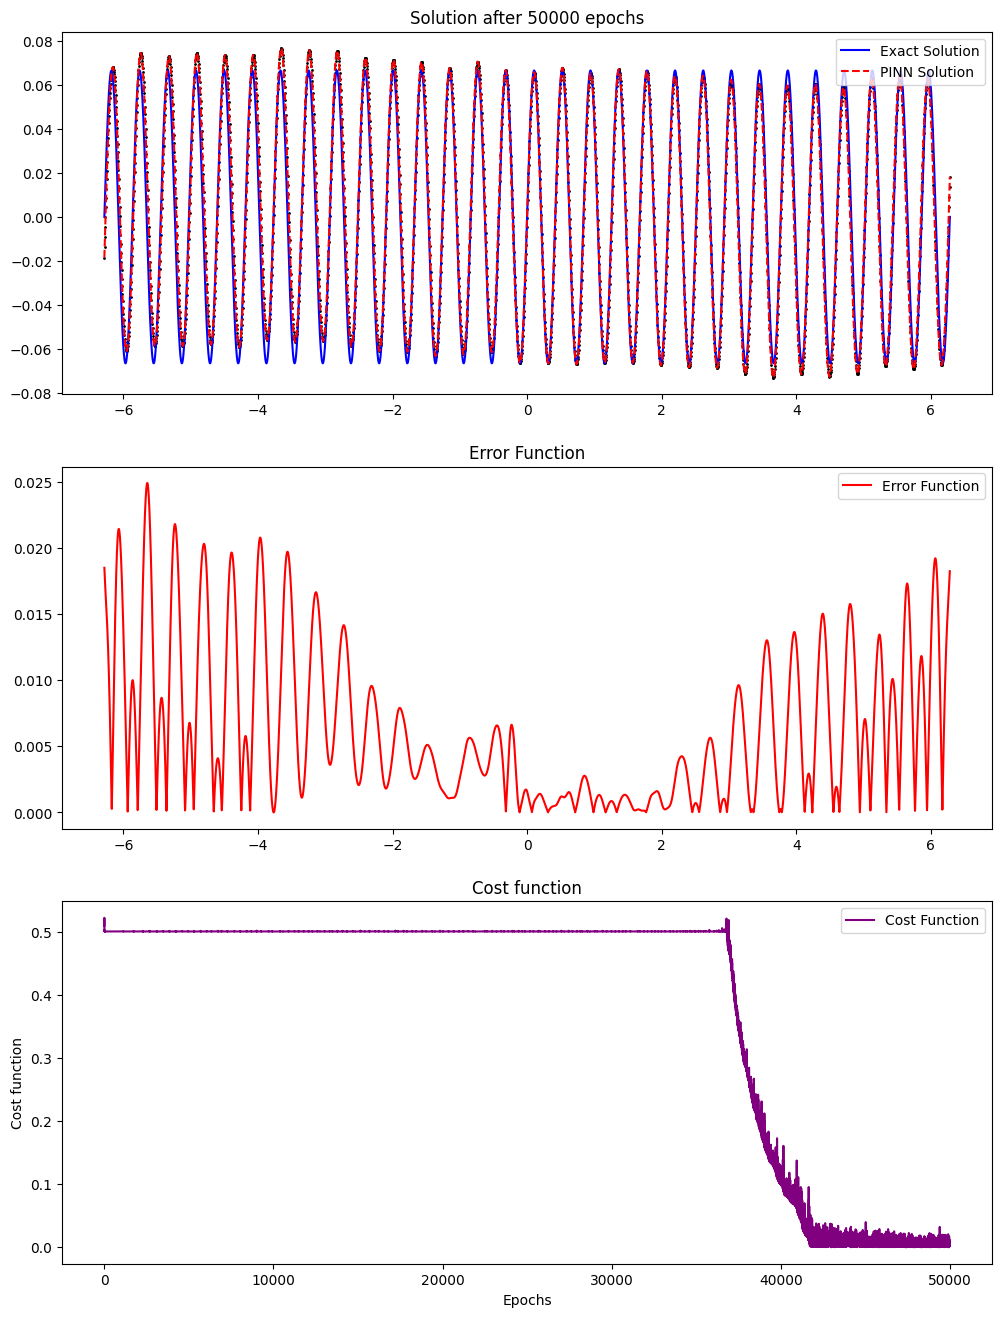

In [56]:
plot_solution(model_test_b3, x_test_b, x_train_b, u_exact_b3, costs_b3, EPOCHS)

#### c)

##### ansatz cost

In [10]:
def ansatz_residual_loss(model, x, omega):
    x = x.requires_grad_(True)
    u = torch.tanh(omega * x) * model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_x - torch.cos(omega* x)) ** 2)

##### model - b3 parameters

In [11]:
OMEGA = 15
TRAINING_POINTS = 3_000
TESTING_POINTS = 5_000

x_train_c = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

x_train_c = x_train_c.to(device)

N_HIDDEN = 128
N_LAYERS = 5

model_c = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_c = model_c.to(device)

In [12]:
model_c, costs_c = train(model_c, OMEGA, ansatz_residual_loss, EPOCHS, x_train_c, LR)

model_test_c = model_c

Epoch 0/50000, Loss: 4.94e-01
Epoch 5000/50000, Loss: 2.16e-01
Epoch 10000/50000, Loss: 6.80e-02
Epoch 15000/50000, Loss: 6.24e-03
Epoch 20000/50000, Loss: 6.56e-03
Epoch 25000/50000, Loss: 2.61e-04
Epoch 30000/50000, Loss: 2.72e-04
Epoch 35000/50000, Loss: 2.70e-03
Epoch 40000/50000, Loss: 2.72e-03
Epoch 45000/50000, Loss: 2.81e-03
Epoch 50000/50000, Loss: 2.22e-03


##### testing

In [13]:
x_test_c = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_c = exact_solution(x_test_c, OMEGA)

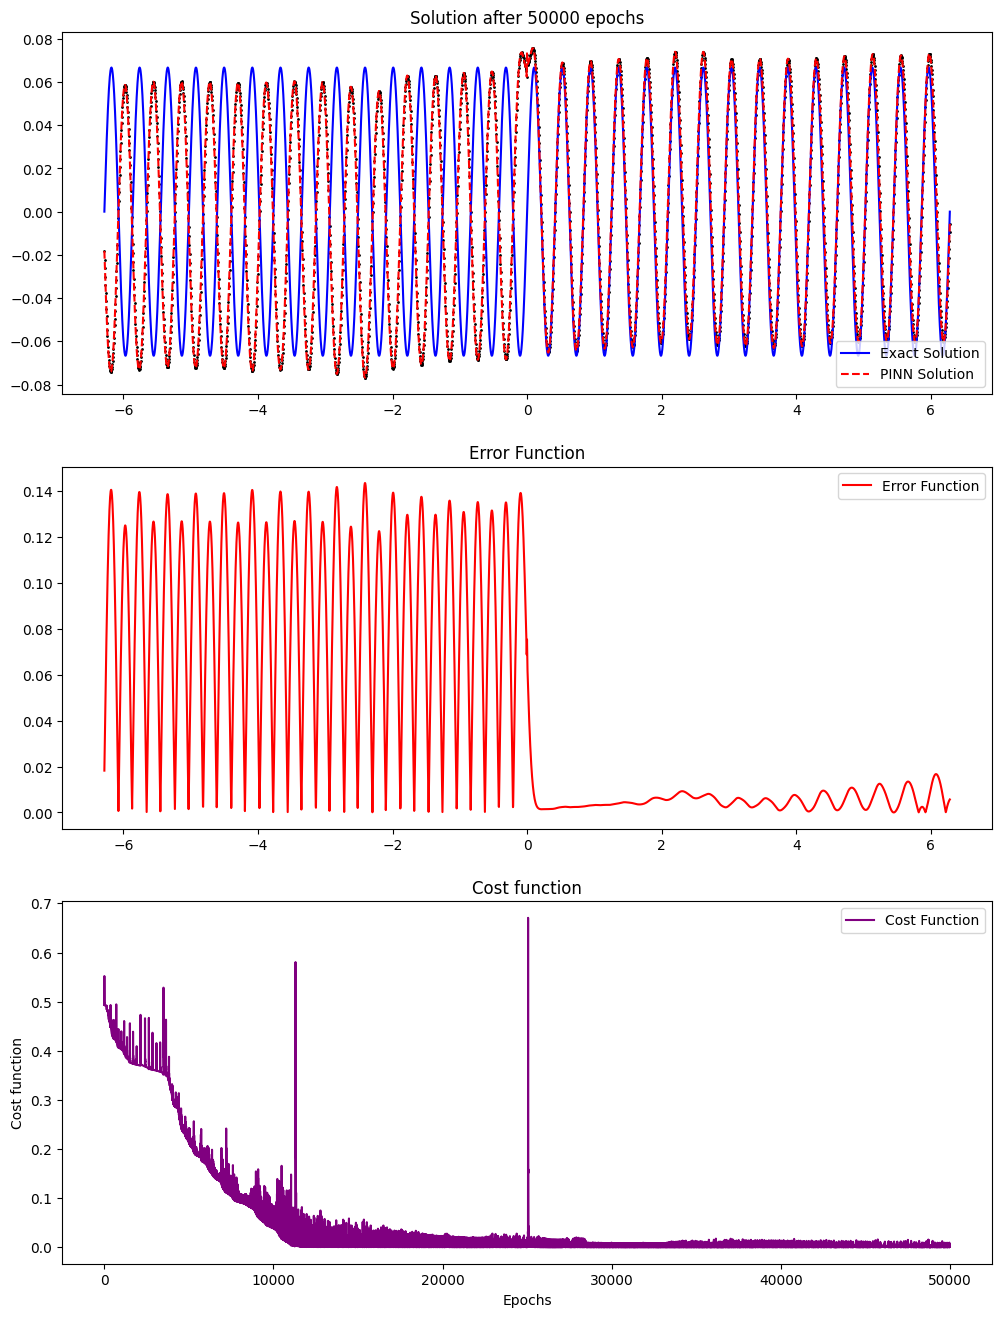

In [14]:
plot_solution(model_test_c, x_test_c, x_train_c, u_exact_c, costs_c, EPOCHS)

#### d)

##### Fourier layer - model

In [54]:
class FourierFCN(FCN):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
        L = N_HIDDEN // 2
        B = np.pi * np.array([2 ** i for i in range(L)])
        self.fcs[0].weight.data = torch.tensor(
            np.concatenate(
                [np.sin(B).reshape(-1, 1), np.cos(B).reshape(-1, 1)], axis=0
            ),
            dtype=torch.float32
        )
        self.fcs[0].bias.data.fill_(0)

In [55]:
OMEGA = 15
TRAINING_POINTS = 3_000
TESTING_POINTS = 5_000

x_train_d = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

x_train_d = x_train_d.to(device)

In [56]:
N_HIDDEN = 16
N_LAYERS = 2

model_d = FourierFCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_d = model_d.to(device)

In [57]:
model_d, costs_d = train(model_d, OMEGA, total_loss, EPOCHS, x_train_d, LR)

model_test_d = model_d

RuntimeError: mat2 must be a matrix, got 1-D tensor

In [36]:
x_test_d = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_d = exact_solution(x_test_d, OMEGA)

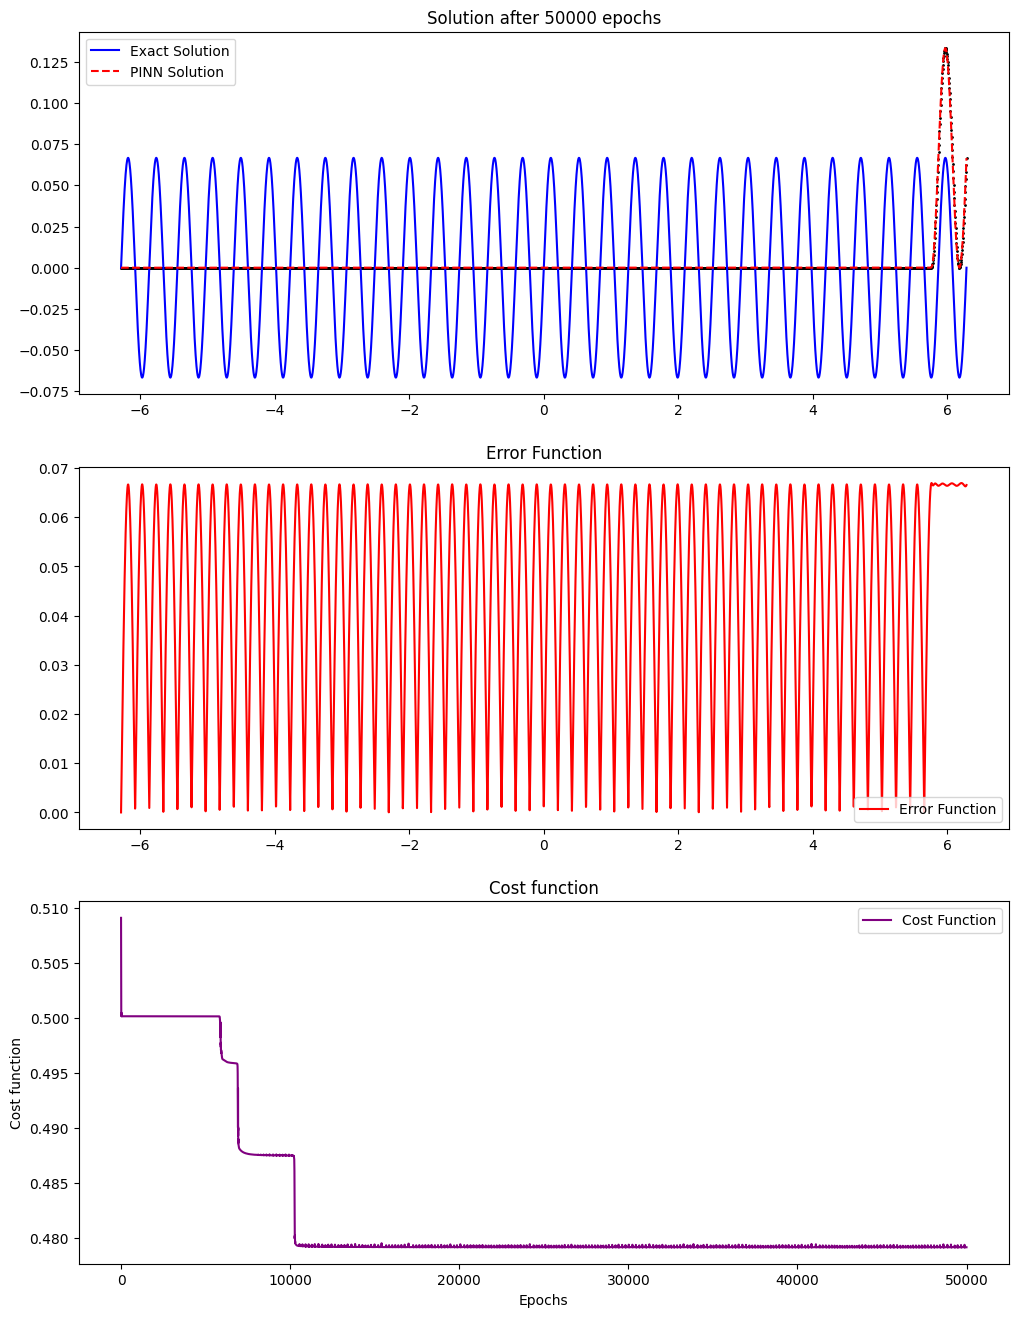

In [37]:
plot_solution(model_test_d, x_test_d, x_train_d, u_exact_d, costs_d, EPOCHS)